### Bitcoin price analysis by Tweets

Dequan Er, Ph.D.

 - Sentiment analysis of Tweets 
 - Build model that predict positive/neutral/negative signals of bitcoin price 
 - Label future tweets data 

 - NLP and sentiment analysis of Tweets 
 - Bi-directional LSTM model 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install vaderSentiment

     |████████████████████████████████| 125 kB 287 kB/s            


In [3]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

from sklearn import preprocessing
import matplotlib.pyplot as plt
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True) 

In [4]:
tweets_raw_file   = '/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv'
tweets_clean_file = './Bitcoin_tweets_clean.csv'
bit_price_file2 = '/kaggle/input/bitcoin-price-history/BTC-USD.csv'
# bit_price_file2 = 'data/BTC-USD.csv'

In [5]:
df_raw = pd.read_csv(tweets_raw_file,low_memory=False)
print(df_raw.shape)
df_raw.head(5)

(2259788, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [6]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|██████████| 22598/22598 [00:48<00:00, 464.29it/s] 


## Sentiment anatweets_clean_fileh Vader
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account

negations and contractions (not good, wasn’t good)
Punctuation (good!!!), CAPS, emotes :), emojis
Intensificators (very, kind of), acronyms ‘lol’
Scores between -1.0 (negative) and 1.0 (positive)

We will use this sentiment analysis of the tweets to calculate a score that will represent the importance of each tweet.

In [7]:
df_clean = pd.read_csv(tweets_clean_file)

In [8]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(2)

100%|██████████| 22598/22598 [00:04<00:00, 4745.09it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,195760,محمد,esfahan,‏‏‏خودت رو به خودت ثابت کن،نه به دیگران,2021-01-02 19:08:56,616.0,1683.0,1712.0,False,2021-06-22 05:22:52,nice project \n\n\n\n\n\nortcoin ort okratech ...,"['ortcoin', 'ort', 'okratech', 'bitcoin', 'air...",Twitter for Android,False,0.5994
1,1135874,Crypto Revolution Merchandise 💚,NaN,Crypto Revolution the Wave of change 👊😎👊 Not y...,2019-10-13 06:16:05,451.0,2045.0,45077.0,False,2021-08-25 07:06:40,Long Bitcoin short the banks 🧐,['Bitcoin'],Twitter Web App,False,0.0000


## Calculate a score for each tweet
To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [9]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(2)

100%|██████████| 22598/22598 [00:01<00:00, 13184.90it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,195760,محمد,esfahan,‏‏‏خودت رو به خودت ثابت کن،نه به دیگران,2021-01-02 19:08:56,616.0,1683.0,1712.0,False,2021-06-22 05:22:52,nice project \n\n\n\n\n\nortcoin ort okratech ...,"['ortcoin', 'ort', 'okratech', 'bitcoin', 'air...",Twitter for Android,False,0.5994,1025.108064
1,1135874,Crypto Revolution Merchandise 💚,NaN,Crypto Revolution the Wave of change 👊😎👊 Not y...,2019-10-13 06:16:05,451.0,2045.0,45077.0,False,2021-08-25 07:06:40,Long Bitcoin short the banks 🧐,['Bitcoin'],Twitter Web App,False,0.0000,0.000000


## read Bitcoin price 

In [10]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


In [11]:
# sentiment analysis 
df_clean = df_clean.drop_duplicates()
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

crypto_usd = df_price.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

In [12]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']
# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [13]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

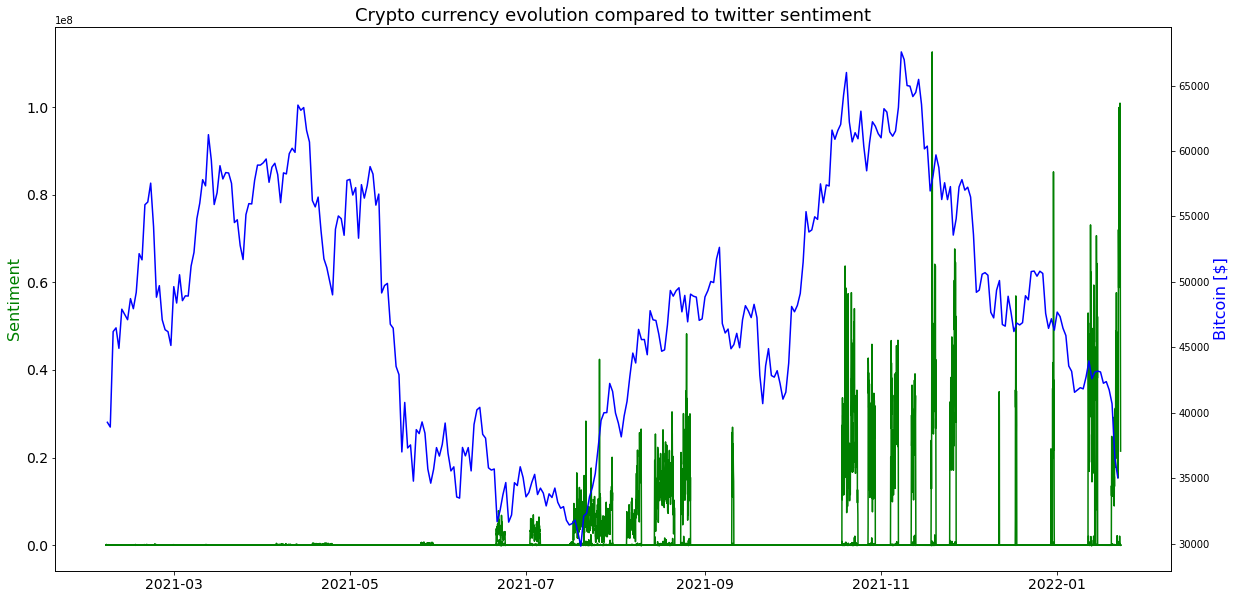

In [14]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

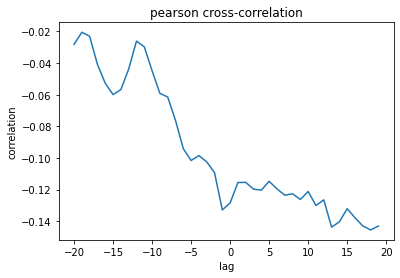

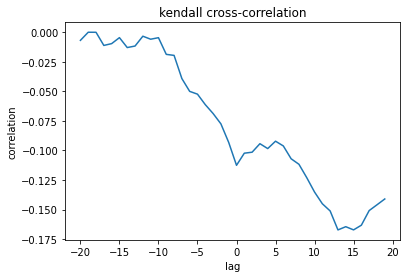

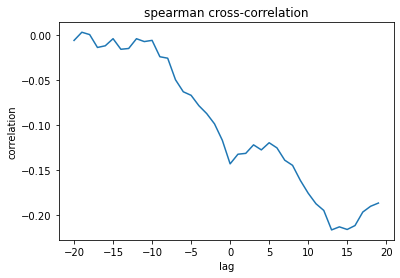

In [15]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Normalization

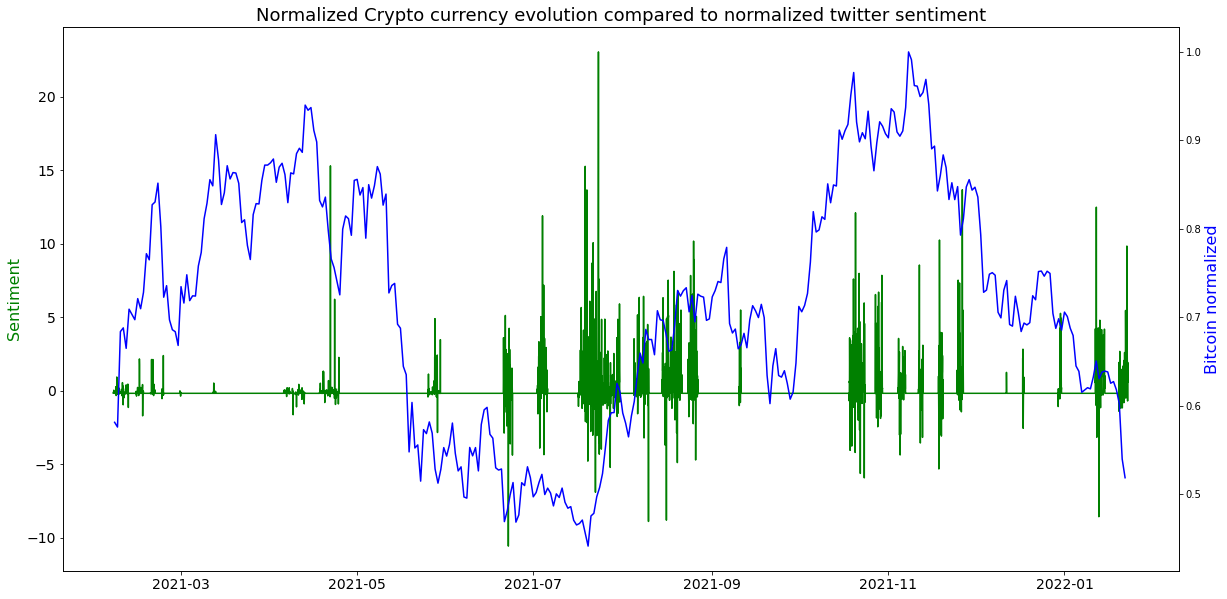

In [16]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

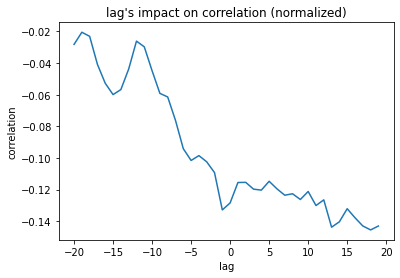

In [17]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative of Crypto price 

In [18]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

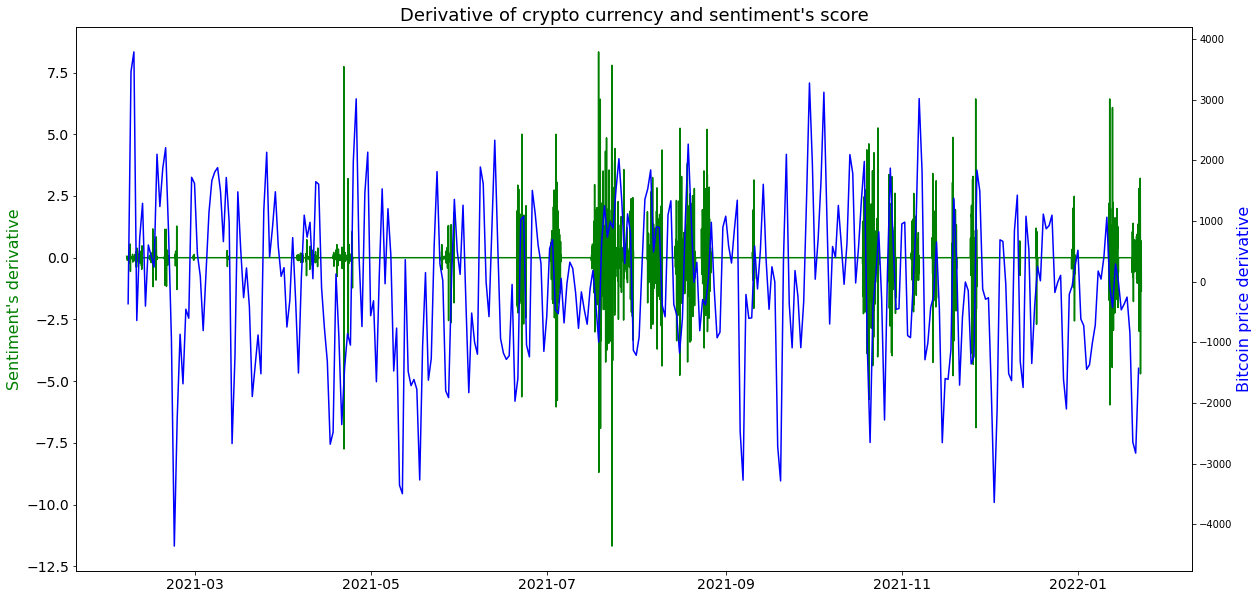

In [19]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

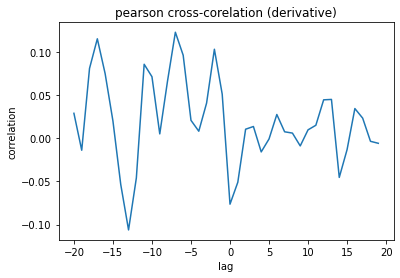

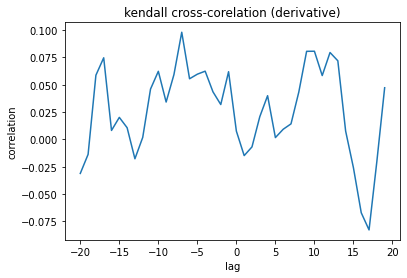

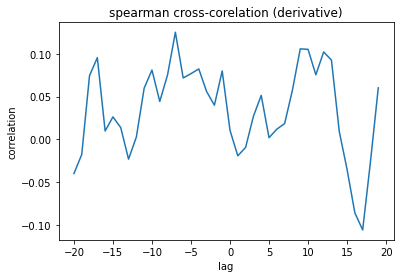

In [20]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

# Part 2 NLP Modeling 

In [21]:
! pip install textblob 
from textblob import TextBlob

df = df_clean.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,nice project \n\n\n\n\n\nortcoin ort okratech ...
1,Long Bitcoin short the banks 🧐
2,Top Trending Cryptocurrency Post - DOGECOIN Se...
3,Can one expect another wave of BTC's decline s...
4,We will see…\n\nbitcoin btc bnb band bake $btc...


In [22]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between

In [23]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [24]:
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()

,tweets,cleaned_tweets,date_clean
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22
1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02
3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24
4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29


In [25]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [26]:
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
def observe_period(period):
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    res = res.apply(crypto_price_cate)
    return res 

time_sentiment = observe_period(7) # compare price ratio in 7 days. price_7_days_later/ price_now 
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [27]:
# may takes time 
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22,positive,1.00,0.600
1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25,negative,0.35,-0.025
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02,negative,0.40,0.250
3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24,negative,0.00,0.000
4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29,positive,0.00,0.000


In [28]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()
df.to_csv('./df_data.csv')

## Model preparation 

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [30]:
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,nice project \n\n\n\n\n\nortcoin ort okratech ...,nice project ortcoin ort okratech bitcoin aird...,2021-06-22,positive,1.00,0.600,positive,True
1,Long Bitcoin short the banks 🧐,Long Bitcoin short bank,2021-08-25,negative,0.35,-0.025,negative,True
2,Top Trending Cryptocurrency Post - DOGECOIN Se...,Top Trending Cryptocurrency Post DOGECOIN Sell...,2021-07-02,negative,0.40,0.250,positive,False
3,Can one expect another wave of BTC's decline s...,Can one expect another wave BTC decline soon v...,2021-07-24,negative,0.00,0.000,neutral,False
4,We will see…\n\nbitcoin btc bnb band bake $btc...,We see bitcoin btc bnb band bake btc dCc xZ dP,2021-05-29,positive,0.00,0.000,neutral,False


In [31]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [32]:
seed = 38 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17936,) (4484,) (17936, 3) (4484, 3)


In [33]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [34]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(17936, 30) (4484, 30)


In [35]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 3

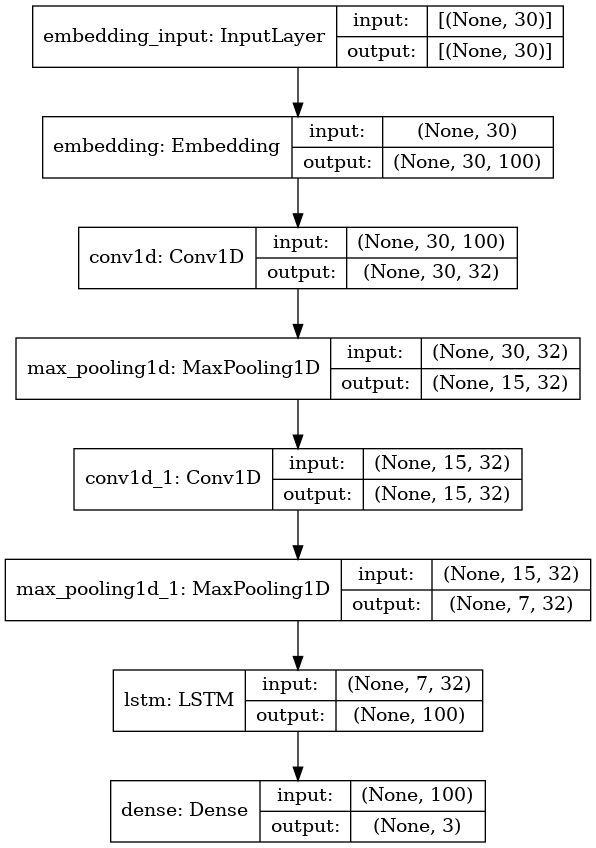

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

2022-02-03 01:56:45.462012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
141/141 - 14s - loss: 0.6622 - accuracy: 0.7189 - val_loss: 0.4014 - val_accuracy: 0.8533
Epoch 2/10
141/141 - 9s - loss: 0.2332 - accuracy: 0.9215 - val_loss: 0.2251 - val_accuracy: 0.9266
Epoch 3/10
141/141 - 9s - loss: 0.0742 - accuracy: 0.9783 - val_loss: 0.2399 - val_accuracy: 0.9338
Epoch 4/10
141/141 - 8s - loss: 0.0313 - accuracy: 0.9924 - val_loss: 0.2399 - val_accuracy: 0.9306
Epoch 5/10
141/141 - 9s - loss: 0.0207 - accuracy: 0.9948 - val_loss: 0.2970 - val_accuracy: 0.9331
Epoch 6/10
141/141 - 9s - loss: 0.0140 - accuracy: 0.9961 - val_loss: 0.2875 - val_accuracy: 0.9338
Epoch 7/10
141/141 - 10s - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.3232 - val_accuracy: 0.9300
Epoch 8/10
141/141 - 9s - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.3296 - val_accuracy: 0.9340
Epoch 9/10
141/141 - 9s - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.3596 - val_accuracy: 0.9309
Epoch 10/10
141/141 - 9s - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.3547 - val_accuracy: 0.93

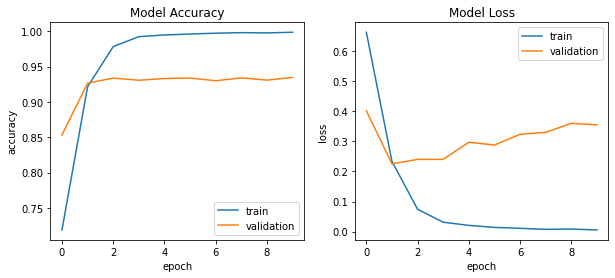

In [38]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [39]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	93.5%
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       478
           1       0.94      0.95      0.95      1782
           2       0.95      0.95      0.95      2224

    accuracy                           0.93      4484
   macro avg       0.91      0.90      0.90      4484
weighted avg       0.93      0.93      0.93      4484



2    2224
1    1782
0     478
dtype: int64
2    2240
1    1800
0     444
dtype: int64


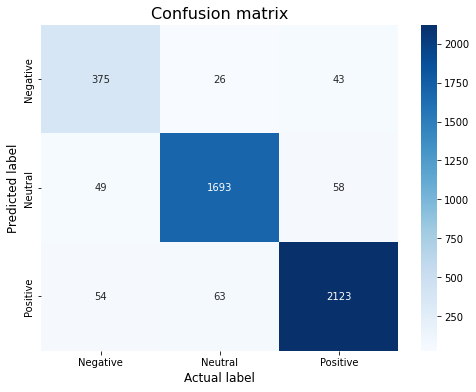

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Model2 

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 nice project ortcoin ort okratech bitcoin airdrop freelancer crypto dRywbnSVCo
After Tokenization & Padding 
 [ 204    5 2119 1795 2120    1   11 1735    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [42]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (13452, 50) (13452, 3)
Validation Set:  (4484, 50) (4484, 3)
Test Set:  (4484, 50) (4484, 3)


In [43]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [45]:
vocab_size = 5000
embedding_size = 32
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

In [46]:
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

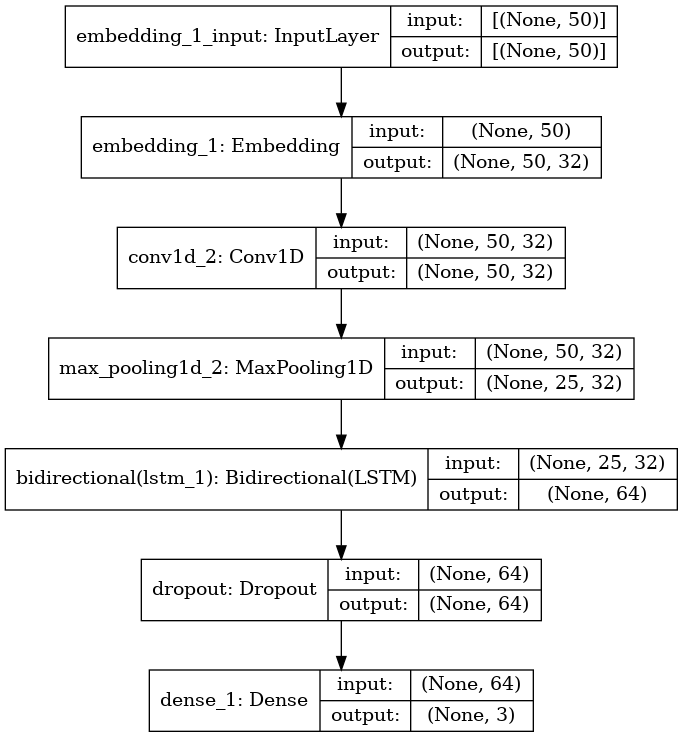

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [49]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/50
106/106 [==============================] - 12s 65ms/step - loss: 0.9725 - accuracy: 0.4983 - precision: 0.5279 - recall: 0.1401 - val_loss: 0.9532 - val_accuracy: 0.4931 - val_precision: 0.6894 - val_recall: 0.2183
Epoch 2/50
106/106 [==============================] - 6s 54ms/step - loss: 0.9462 - accuracy: 0.5101 - precision: 0.5526 - recall: 0.2829 - val_loss: 0.9451 - val_accuracy: 0.4931 - val_precision: 0.6302 - val_recall: 0.3492
Epoch 3/50
106/106 [==============================] - 6s 59ms/step - loss: 0.9340 - accuracy: 0.5387 - precision: 0.6050 - recall: 0.3062 - val_loss: 0.9237 - val_accuracy: 0.5865 - val_precision: 0.6547 - val_recall: 0.3247
Epoch 4/50
106/106 [==============================] - 6s 53ms/step - loss: 0.9063 - accuracy: 0.5914 - precision: 0.6471 - recall: 0.4066 - val_loss: 0.8900 - val_accuracy: 0.6010 - val_precision: 0.6440 - val_recall: 0.4902
Epoch 5/50
106/106 [==============================] - 6s 55ms/step - loss: 0.8852 - accuracy: 0.606

In [50]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8753
Precision : 0.8858
Recall    : 0.8615
F1 Score  : 0.8735


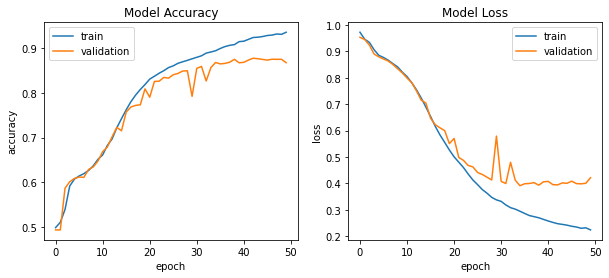

In [51]:
plot_training_hist(history)

2    2195
1    1833
0     456
dtype: int64
2    2298
1    1831
0     355
dtype: int64


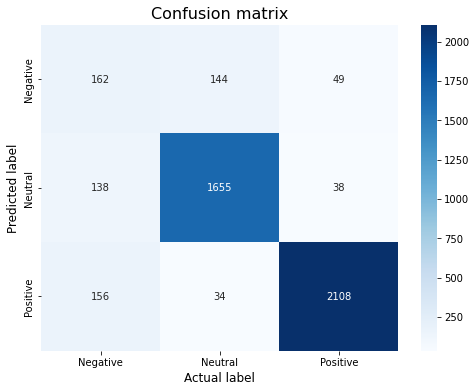

In [52]:
plot_confusion_matrix(model, X_test, y_test)